<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/Modele000002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

##Python / Colab
from google.colab import files
from google.colab import drive
import os
from IPython.display import Image as imgIPython
from IPython.display import clear_output,display
import IPython
## Tensorflow keras
try:
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,Conv2D,Convolution2D,Activation,Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Dropout,Reshape,BatchNormalization
from tensorflow.keras.layers import concatenate,Concatenate,Subtract,Multiply,Average,Add
from tensorflow.keras.layers import UpSampling2D, Reshape,Flatten
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import models
from tensorflow.keras.models import Model
import tensorflow.keras.losses
## Math libraries
import numpy as np
import scipy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
##Images
from PIL import Image
import cv2
## Graph
from graphviz import render
from graphviz import Digraph,Graph
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
#Dataset
from __future__ import absolute_import, division, print_function, unicode_literals
import random
import pathlib
import shutil

     |████████████████████████████████| 511.7MB 33kB/s 
     |████████████████████████████████| 2.9MB 53.4MB/s 
     |████████████████████████████████| 2.8MB 42.2MB/s 
     |████████████████████████████████| 460kB 43.8MB/s 
     |████████████████████████████████| 778kB 25.1MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/TIPE


#Dataset

In [0]:
#@title { display-mode: "form" }

dossier_TIPE = "/content/drive/My Drive/TIPE/"#@param {type:"string"}

Vérification des datasets

In [3]:
path = dossier_TIPE+"Galaxies_resized/"
dossiers = ["Train","Validation","Test"]
compte = []
for d in dossiers:
    compte.append(len(os.listdir(path+d)))
print([c/sum(compte) for c in compte])

[0.6089108910891089, 0.297029702970297, 0.09405940594059406]


Création des classes de dataset Tensorflow

max :  tf.Tensor(0.8196079, shape=(), dtype=float32)


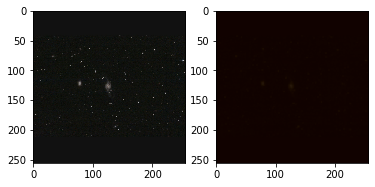

In [4]:
data = tf.data.Dataset.list_files(dossier_TIPE+"Galaxies_resized/"+"Train"+"/*.jpg").shuffle(len(os.listdir(dossier_TIPE+"Galaxies_resized/"+"Train")))

#Bruit gaussien origine : https://stackoverflow.com/questions/59286171/gaussian-blur-image-in-dataset-pipeline-in-tensorflow
def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)


def apply_blur(img):
    img = tf.reshape(img,[1,256,256,3])
    blur = _gaussian_kernel(3, 2, 3, img.dtype)
    img = tf.nn.depthwise_conv2d(img, blur, [1,1,1,1], 'SAME')
    return tf.reshape(img,[256,256,3])

def open(x):
    """Modification par image"""
    img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    print("max : ",tf.reduce_max(img))
    img = tf.image.resize(img, [256, 256])
    img = tf.clip_by_value(img,0,1)
    #Bruitage
    img_noise = tf.image.adjust_saturation(img,.8)
    img_noise = apply_blur(img_noise)
    img_noise = tf.image.adjust_contrast(img_noise,tf.reduce_sum(tf.random.uniform(shape=(1,),dtype=tf.float32,minval=0.1,maxval=0.2)))
    ajout = 0.1
    img_noise = img_noise+tf.concat([tf.ones(shape=[256,256,1])*ajout,tf.zeros(shape=[256,256,2])],axis=-1)
    img_noise = tf.image.adjust_brightness(img_noise,-ajout)
    img_noise = tf.image.adjust_hue(img_noise,tf.reduce_sum(tf.random.uniform(shape=(1,),dtype=tf.float32,minval=0.06,maxval=0.09)))
    img_noise = tf.clip_by_value(img_noise,0,1)
    return img,img_noise

res = data.batch(5)
file_path = next(iter(res))
image,img_noise = open(file_path[0])
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(img_noise)



In [0]:
#D'après https://stackoverflow.com/questions/54590363/create-tensorflow-dataset-from-image-local-directory
class ArtificialDataset(tf.data.Dataset):
    def process_path(file_path):
        img_clean = tf.io.read_file(file_path)
        #Code 
        return tf.io.read_file(file_path), label
    @staticmethod
    def list_files(file_pattern, nom, batch_size, shuffle=None, seed=None):
        donnees = os.listdir(dossier_TIPE+"Galaxies_resized/"+cls.nom)
        random.shuffle(donnees)
        self.donnees = tf.data.Dataset.list_files(dossier_TIPE+"Galaxies_resized/"+nom+"/*.jpg").shuffle(len(os.listdir(dossier_TIPE+"Galaxies_resized/"+nom))).batch(5)
        return super().list_files(file_pattern, shuffle, seed)
    def _generator(cls):
        
            yield (sample_idx,)
    
    def __new__(cls):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.int64,
            output_shapes=(1,),
            args=()
        )
